# Predicting BitCoin prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [1]:
# Change Keras backend
from keras import backend as K
import os
os.environ['KERAS_BACKEND'] = "cntk"

In [2]:
# install dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# 1. Get historic stock prices
data = pd.read_csv("/Users/Jonathan/Desktop/datascience-ca1/Cryptocurrency/file/gemini_BTCUSD_2015_1min.csv")

# Data review

In [4]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1451606340,2015-12-31 23:59:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
1,1451606280,2015-12-31 23:58:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
2,1451606220,2015-12-31 23:57:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
3,1451606160,2015-12-31 23:56:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
4,1451606100,2015-12-31 23:55:00,BTCUSD,429.95,429.95,429.95,429.95,0.0


In [5]:
data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
121575,1444311840,2015-10-08 13:44:00,BTCUSD,242.96,242.96,242.96,242.96,0.033491
121576,1444311780,2015-10-08 13:43:00,BTCUSD,242.95,242.96,242.95,242.96,0.010000
121577,1444311720,2015-10-08 13:42:00,BTCUSD,242.95,242.95,242.95,242.95,0.000000
121578,1444311660,2015-10-08 13:41:00,BTCUSD,242.50,242.95,242.50,242.95,0.001000
121579,1444311600,2015-10-08 13:40:00,BTCUSD,0.00,242.50,0.00,242.50,0.050000


In [6]:
data.columns

Index(['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data.shape

(121580, 8)

In [8]:
data.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,1.215800e+05,121580.000000,121580.000000,121580.000000,121580.000000,121580.000000
mean,1.447959e+09,355.978047,356.052682,355.907340,355.981583,0.447339
std,2.105836e+06,68.462155,68.676106,68.239924,68.454872,3.574566
min,1.444312e+09,0.000000,242.500000,0.000000,236.000000,0.000000
25%,1.446135e+09,310.000000,310.000000,310.000000,310.000000,0.000000
50%,1.447959e+09,353.780000,353.780000,353.500000,353.780000,0.000000
75%,1.449783e+09,420.500000,420.605000,420.500000,420.500000,0.000000
max,1.451606e+09,2200.000000,2200.000000,2200.000000,2200.000000,224.265300


In [9]:
data.dtypes

Unix Timestamp      int64
Date               object
Symbol             object
Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
dtype: object

In [10]:
data.set_index('Unix Timestamp', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121580 entries, 1451606340 to 1444311600
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    121580 non-null  object 
 1   Symbol  121580 non-null  object 
 2   Open    121580 non-null  float64
 3   High    121580 non-null  float64
 4   Low     121580 non-null  float64
 5   Close   121580 non-null  float64
 6   Volume  121580 non-null  float64
dtypes: float64(5), object(2)
memory usage: 7.4+ MB


In [11]:
data.sort_index(inplace=True)

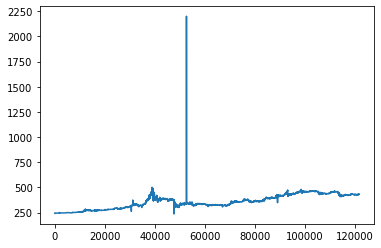

In [12]:
data_close = data['Close']
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
data_close = scaler.fit_transform(data_close)
data_close

array([[0.00330957],
       [0.0035387 ],
       [0.0035387 ],
       ...,
       [0.09875255],
       [0.09875255],
       [0.09875255]])

In [15]:
# split data into train and test
train_size = int(len(data_close)*0.7)
test_size = len(data_close) - train_size

data_train, data_test = data_close[0:train_size, :], data_close[train_size:len(data_close), :]
print('Split data into train and test: ', len(data_train), len(data_test))

Split data into train and test:  85106 36474


In [16]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(data_train, series)
testX, testY = create_ts(data_test, series)

In [17]:
trainX

array([[0.00330957, 0.0035387 , 0.0035387 , ..., 0.00354379, 0.00354379,
        0.00354379],
       [0.0035387 , 0.0035387 , 0.00354379, ..., 0.00354379, 0.00354379,
        0.00354379],
       [0.0035387 , 0.00354379, 0.00354379, ..., 0.00354379, 0.00354379,
        0.00354379],
       ...,
       [0.07892057, 0.07892057, 0.07892057, ..., 0.07892057, 0.07892057,
        0.07892057],
       [0.07892057, 0.07892057, 0.07892057, ..., 0.07892057, 0.07892057,
        0.07892057],
       [0.07892057, 0.07892057, 0.07892057, ..., 0.07892057, 0.07892057,
        0.07892057]])

In [18]:
trainX[0]

array([0.00330957, 0.0035387 , 0.0035387 , 0.00354379, 0.00354379,
       0.00354379, 0.00354379])

In [19]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
# build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

2021-12-03 09:07:15.022164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 09:07:15.382268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
2660/2660 [==============================] - 38s 13ms/step - loss: 7.3284e-05
Epoch 2/100
2660/2660 [==============================] - 36s 14ms/step - loss: 4.5225e-05
Epoch 3/100
2660/2660 [==============================] - 26s 10ms/step - loss: 4.1111e-05
Epoch 4/100
2660/2660 [==============================] - 25s 10ms/step - loss: 3.7602e-05
Epoch 5/100
2660/2660 [==============================] - 25s 10ms/step - loss: 3.4612e-05
Epoch 6/100
2660/2660 [==============================] - 27s 10ms/step - loss: 3.2648e-05
Epoch 7/100
2660/2660 [==============================] - 25s 9ms/step - loss: 3.0227e-05
Epoch 8/100
2660/2660 [==============================] - 26s 10ms/step - loss: 2.8416e-05
Epoch 9/100
2660/2660 [==============================] - 30s 11ms/step - loss: 2.6912e-05
Epoch 10/100
2660/2660 [==============================] - 34s 13ms/step - loss: 2.5249e-05
Epoch 11/100
2660/2660 [==============================] - 26s 10ms/step - loss: 2.4303e-05
Epoch 12/

2660/2660 [==============================] - 35s 13ms/step - loss: 2.1692e-05
Epoch 92/100
2660/2660 [==============================] - 36s 14ms/step - loss: 2.1856e-05
Epoch 93/100
2660/2660 [==============================] - 36s 13ms/step - loss: 2.2229e-05
Epoch 94/100
2660/2660 [==============================] - 35s 13ms/step - loss: 2.1946e-05
Epoch 95/100
2660/2660 [==============================] - 42s 16ms/step - loss: 2.1964e-05
Epoch 96/100
2660/2660 [==============================] - 40s 15ms/step - loss: 2.1452e-05
Epoch 97/100
2660/2660 [==============================] - 36s 14ms/step - loss: 2.1697e-05
Epoch 98/100
2660/2660 [==============================] - 44s 16ms/step - loss: 2.1972e-05
Epoch 99/100
2660/2660 [==============================] - 43s 16ms/step - loss: 2.2067e-05
Epoch 100/100
2660/2660 [==============================] - 41s 15ms/step - loss: 2.1525e-05


In [21]:
# test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

# unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [22]:
# lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 8.86252475840093
Test score: %.2f rmse 0.7766434009112483


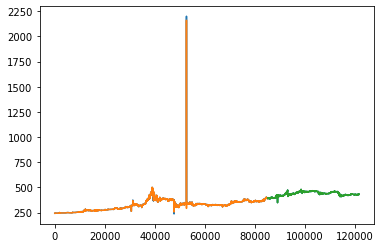

In [23]:
# lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(data_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(data_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(data_close)-1, :] = testPredictions

# plot on graph
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()